<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/BlackPlague-SIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys

sys.path.append('/content/drive/My Drive/Colab Notebooks')

import pytwalk as twalk

In [0]:
import numpy as np
import scipy
import scipy.stats
import scipy.integrate
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit
from matplotlib import cm
import emcee
import pystan
import time

Text(0.5, 1.0, 'Cumulative deaths Elyam, UK 1666')

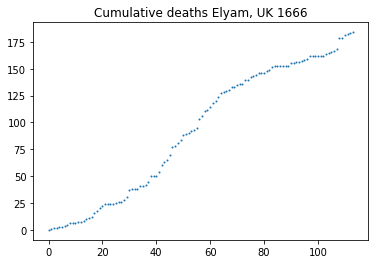

In [12]:

''' Second black plague outbreak in Elyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261    

def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )


plt.scatter( ts,y, s=1)
plt.title('Cumulative deaths Elyam, UK 1666')


In [0]:

def logprior( Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         a= -alpha-beta+I0*np.log( 5/N )+(N-I0)*np.log( 1- 5/N   )
         b=scipy.special.loggamma(N+1)- scipy.special.loggamma(I0+1)- scipy.special.loggamma(N-I0+1)
         return a+b
    else:
         return -np.inf
    
    
def logL(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    n=len(y)
    X0=np.array( [N-I0, I0, 0] )
    Xt = odeint( SIR, X0, ts, args=(alpha,beta,I0,))  
    It= Xt[:,1]
    It[It<0]=0
    Rt=Xt[:,2]
    Rt[Rt>261]=261
    ll=0
    ll=ll+np.log( It[n-2]/N +1e-300 )+(N-1)*np.log( 1- It[n-2]/N    )+N*np.log( 1- It[n-1]/N  )
    ll=ll+ np.sum(y[1:n]* np.log( Rt[1:] /N ))+np.sum( (N-y[1:])  *np.log(   1- Rt[1:]/N +1e-300 ))
    return ll
    

def lpost(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=N  ):
         return -logprior(Theta)-logL(Theta) 
    else:
         return np.inf
  

def fpoints(f, args, theta,  pars , lb, upb, m=100):
    '''f is the objective function to be plotted
       args are the arguments of f as a list
       theta is the vector of true parameters
       pars are the parameters to be plotted (passed as an array)
       lb: array of lower bounds
       upb:array of upper bounds
       '''
       
    xx = np.linspace(lb[0], upb[0], m)
    yy = np.linspace(lb[1], upb[1], m)
    xx, yy = np.meshgrid(xx, yy)
    Z = np.zeros(shape=[m, m])
    mask = np.zeros( theta.shape, dtype=bool )
    mask[pars] = True
    temp=np.zeros(theta.shape)
    for i in range( m ):
        for j in range( m ):
            temp[mask]=np.array( [xx[i][j], yy[i][j]] )
            temp[~mask]= theta[~mask]
            #Z[i][j] = f( temp , args)
            Z[i][j] = f( temp )
    return xx,yy,Z 

def pContour(xx,yy,Z,c=100):
    plt.contour( xx, yy, Z, c, colors='b' )
    plt.xlabel( r'$\theta_1$' )
    plt.ylabel( r'$\theta_2$' )
    plt.title( r'Objective Function Contours' )
    plt.show()

def pSurface(xx,yy, Z):
    fig = plt.figure()
    ax = plt.axes( projection='3d' )
    ax.plot_surface( xx, yy, Z, cmap='Spectral')
    # ax.contour3D(xx, yy, Z, 30, cmap='binary')
    ax.set_xlabel( r'$\theta_1$' )
    ax.set_ylabel( r'$\theta_2$' )
    ax.set_zlabel( r'$Posterior Surface' )
    ax.view_init( 60, 35 )
    fig






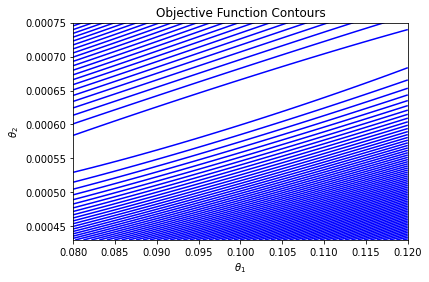

In [14]:
xx,yy,Z= fpoints(f= lpost,args=1, theta= np.array([ 0.09 , 0.0007 , 5 ]) ,
                  pars= np.array([ 0,1]),
                  lb=np.array([ 0.080, 0.00043 ])  , upb= np.array([ .120 , 0.00075  ])  , m=100 )



pContour( xx, yy, Z , c=100) 


In [0]:


def p0(): #prior function for the t walk
    a=scipy.stats.uniform.rvs(0, 1 , 1)
    b= scipy.stats.uniform.rvs(0, 1 , 1)
    c=scipy.stats.uniform.rvs(1,9, 1)
   
    return np.array([a[0],b[0],c[0]])


def supp(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=15 and alpha<1 and beta<1  ):
         return True
    else:
        return False



In [90]:

T=500000 #number of iterations
#x0= np.array([1.11528561e-01, 7.42622491e-04, 5.00000000e+00])
#xp0=np.array([1.03351566e-01, 6.55532405e-04, 4.29146012e+00])
x0=p0()
xp0=p0()

tchain = twalk.pytwalk( n=3, U=lpost, Supp=supp )
tchain.Run( T=T , x0= x0 , xp0=xp0)



pytwalk: Running the twalk with 500000 iterations .  Thu, 04 Jun 2020, 04:46:09.
       Finish by Thu, 04 Jun 2020, 05:28.


/content/drive/My Drive/Colab Notebooks/pytwalk.py:302: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)
/content/drive/My Drive/Colab Notebooks/pytwalk.py:316: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)
/content/drive/My Drive/Colab Notebooks/pytwalk.py:341: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))


pytwalk:      38912 iterations so far. Finish by Thu, 04 Jun 2020, 04:52.
pytwalk:     114688 iterations so far. Finish in approx. 5 min and 7 sec.
pytwalk:     266240 iterations so far. Finish in approx. 3 min and 5 sec.
pytwalk: finished, Thu, 04 Jun 2020, 04:52:47.


1

Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[8.73925560e-02 1.57126569e-01 1.25691302e-04 0.00000000e+00]
Global acceptance rate: 0.12038
AutoMaxlag: maxlag= 406.
Integrated Autocorrelation Time:   124.5, IAT/n:    41.5
AutoMaxlag: maxlag= 406.
(450001, 4)


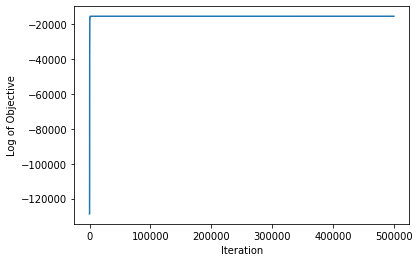

In [91]:

tchain.Ana()
tchain.IAT()
bi=int(0.10*T)
toutput=tchain.Output[bi:, : ]
print(toutput.shape)


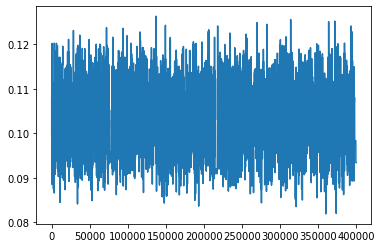

In [92]:
plt.plot( toutput[ bi :,0])

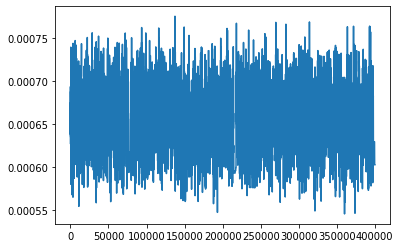

In [93]:
plt.plot( toutput[ bi :,1])

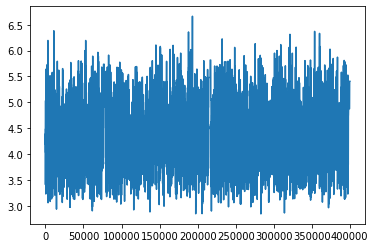

In [94]:
plt.plot( toutput[ bi :,2])

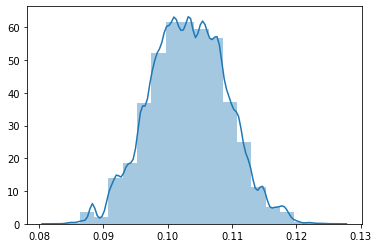

In [95]:
sns.distplot(  toutput[ bi :,0], bins=20)

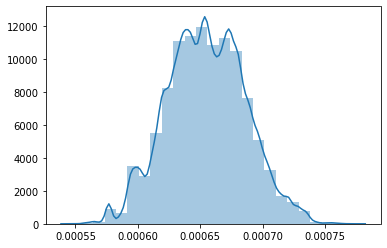

In [96]:
sns.distplot(  toutput[bi :,1] , bins=25  )

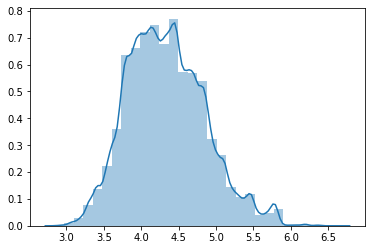

In [97]:
sns.distplot(  toutput[ bi:,2] ,  bins=30 )

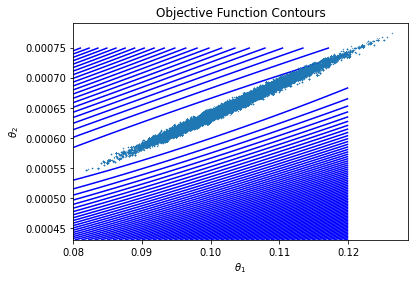

In [98]:

plt.plot( toutput[ bi :,0] , toutput[ bi :,1],'.', markersize=0.5  ) 
pContour( xx, yy, Z , c=100) 

In [0]:
# emcee


def post_emcee(Theta):
    alpha=Theta[0]
    beta=Theta[1]
    I0=Theta[2]
    if( alpha>0 and beta>0 and I0>=1 and I0<=10 and alpha<1 and beta<1  ):
         return logprior(Theta)+logL(Theta) 
    else:
         return -np.inf
    

def p0_emcee(nwalkers=1):
    p0=np.zeros([nwalkers,3])
    a=scipy.stats.uniform.rvs(0, 1, nwalkers)
    b= scipy.stats.uniform.rvs(0, 1 , nwalkers)
    c=scipy.stats.uniform.rvs(1,9, nwalkers)
    p0[:,0]=a
    p0[:,1]=b
    p0[:,2]=c
    return p0


In [103]:

nwalkers = 10
T=100000
bi=int(0.10*T)
mc_x0=p0_emcee(nwalkers)

ndim=mc_x0.shape[1]


sampler =  emcee.EnsembleSampler(nwalkers, ndim, post_emcee )

start=time.time()
sampler.run_mcmc(mc_x0, T, progress=True)
end=time.time()


total_time=end-start
print('total time: ',total_time/60)

samples = sampler.get_chain(discard=bi, flat=True)
print('Shape of samples: ',samples.shape)

emcee_chains = sampler.get_chain(discard=bi)


100%|██████████| 40000/40000 [11:55<00:00, 55.90it/s]

total time:  11.92747373978297
Shape of samples:  (720000, 3)


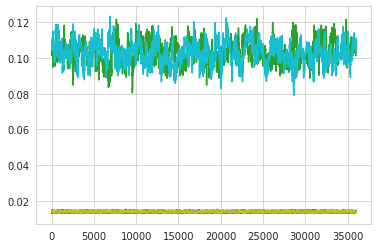

In [105]:
# Set theme
sns.set_style('whitegrid')


plt.plot(emcee_chains[:,0,0 ])
plt.plot(emcee_chains[:,1,0 ])
plt.plot(emcee_chains[:,2,0 ])
plt.plot(emcee_chains[:,3,0 ])
plt.plot(emcee_chains[:,4,0 ])
plt.plot(emcee_chains[:,5,0 ])
plt.plot(emcee_chains[:,6,0 ])
plt.plot(emcee_chains[:,7,0 ])
plt.plot(emcee_chains[:,8,0 ])
plt.plot(emcee_chains[:,9,0 ])



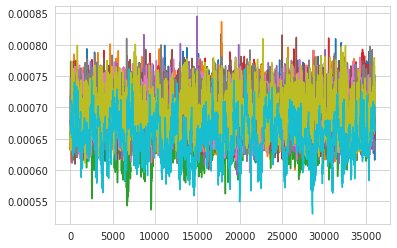

In [106]:
plt.plot(emcee_chains[:,0,1 ])
plt.plot(emcee_chains[:,1,1 ])
plt.plot(emcee_chains[:,2,1 ])
plt.plot(emcee_chains[:,3,1 ])
plt.plot(emcee_chains[:,4,1 ])
plt.plot(emcee_chains[:,5,1 ])
plt.plot(emcee_chains[:,6,1 ])
plt.plot(emcee_chains[:,7,1 ])
plt.plot(emcee_chains[:,8,1 ])
plt.plot(emcee_chains[:,9,1 ])

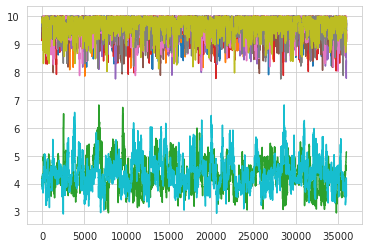

In [107]:
plt.plot(emcee_chains[:,0,2 ])
plt.plot(emcee_chains[:,1,2 ])
plt.plot(emcee_chains[:,2,2 ])
plt.plot(emcee_chains[:,3,2 ])
plt.plot(emcee_chains[:,4,2 ])
plt.plot(emcee_chains[:,5,2 ])
plt.plot(emcee_chains[:,6,2 ])
plt.plot(emcee_chains[:,7,2 ])
plt.plot(emcee_chains[:,8,2 ])
plt.plot(emcee_chains[:,9,2 ])

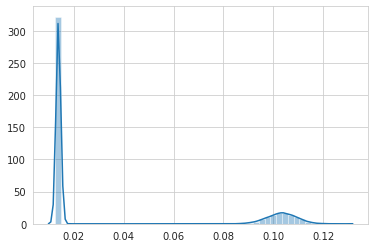

In [108]:



sns.distplot( samples[:,0] )


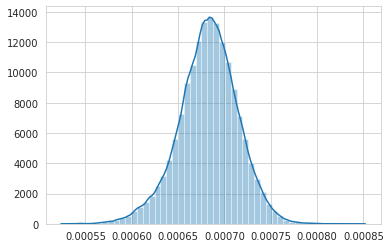

In [110]:
sns.distplot( samples[:,1] )



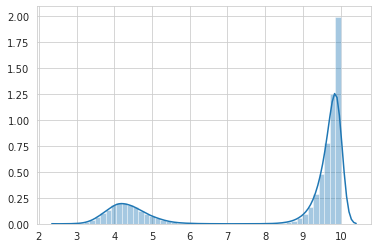

In [119]:
sns.distplot( samples[:,2] )

In [120]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [0]:
from multiprocessing import Pool

mc_x02=p0_emcee(nwalkers)


with Pool() as pool:
  sampler2 =  emcee.EnsembleSampler(nwalkers, ndim, post_emcee, pool=pool )
  start=time.time() 
  sampler2.run_mcmc(mc_x02, T, progress=True)
  end=time.time()
  multi_time = end - start
  print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    




 27%|██▋       | 10649/40000 [03:58<10:44, 45.57it/s]

In [0]:
samples2 = sampler.get_chain(discard=bi, flat=True)
print('Shape of samples: ',samples2.shape)

emcee_chains = sampler.get_chain(discard=bi)